<a href="https://colab.research.google.com/github/divyabala-ai/boston-marathon-clustering/blob/main/boston_marathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Boston Marathon Project**

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering. Specifically, use the tools at hand to determine which clustering solution — including number of clusters and algorithm used — is best for the marathon data.

Once you have a solution you like, write a data story, including visualizations, where you teach the readers something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish.

You must include analysis as follows:

Using K-means and PCA, visualize the clusters for K = 2–10. Include the silhouette scores.

Draw bar graphs (both male & female in different colors) for each cluster. From the bar graphs, you can tell things such as which cluster contains the most number of females (or males).

Draw bar graphs for runners in different ranges of age (dividing by 3 groups: 18–25, 26–40, 40–70 or so) for each cluster (in different colors). From the graph, you should be able to answer questions like: which cluster contains the most young people, which cluster contains the oldest people, etc.

Repeat steps 1–3 using GMM and T-SNE.

Do the same analyses as above (steps 1–4) for finishing time (i.e., determine which group runs fastest).

In [ ]:
# === Imports ===
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

# === Mount Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the CSV file
file_path = '/content/drive/MyDrive/boston_marathon_2017_results.csv'

df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,Bib,Name,Age,M/F,City,State,Country,Citizen,Unnamed: 9,...,25K,30K,35K,40K,Pace,Proj Time,Official Time,Overall,Gender,Division
0,0,11,"Kirui, Geoffrey",24,M,Keringet,NaN,KEN,NaN,NaN,...,1:16:59,1:33:01,1:48:19,2:02:53,0:04:57,-,2:09:37,1,1,1
1,1,17,"Rupp, Galen",30,M,Portland,OR,USA,NaN,NaN,...,1:16:59,1:33:01,1:48:19,2:03:14,0:04:58,-,2:09:58,2,2,2
2,2,23,"Osako, Suguru",25,M,Machida-City,NaN,JPN,NaN,NaN,...,1:17:00,1:33:01,1:48:31,2:03:38,0:04:59,-,2:10:28,3,3,3
3,3,21,"Biwott, Shadrack",32,M,Mammoth Lakes,CA,USA,NaN,NaN,...,1:17:00,1:33:01,1:48:58,2:04:35,0:05:03,-,2:12:08,4,4,4
4,4,9,"Chebet, Wilson",31,M,Marakwet,NaN,KEN,NaN,NaN,...,1:16:59,1:33:01,1:48:41,2:05:00,0:05:04,-,2:12:35,5,5,5


#**Data Cleaning and Preparation for Clustering**

In [ ]:
# Select relevant columns
selected_columns = ['Age', 'M/F', 'Official Time']

df_selected = df[selected_columns].copy()

# Convert 'M/F' column to numeric
df_selected['M/F'] = df_selected['M/F'].map({'M': 0, 'F': 1})

# Convert 'Official Time' to seconds
# Function to convert time strings to seconds
def time_to_seconds(t):
    try:
        parts = t.split(':')
        parts = [int(p) for p in parts]
        if len(parts) == 3:  # HH:MM:SS
            return parts[0]*3600 + parts[1]*60 + parts[2]
        elif len(parts) == 2:  # MM:SS
            return parts[0]*60 + parts[1]
    except:
        return None  # in case of missing or invalid time

# Apply conversion to 'Official Time'
df_selected['Official Time'] = df_selected['Official Time'].apply(time_to_seconds)

# Drop rows with any NaN values
df_selected = df_selected.dropna()

# Verify the cleaned data
df_selected.head()

,Age,M/F,Official Time
0,24,0,7777
1,30,0,7798
2,25,0,7828
3,32,0,7928
4,31,0,7955


# **K-means clustering with PCA-reduced data**

Data before scaling:
   Age  M/F  Official Time
0   24    0           7777
1   30    0           7798
2   25    0           7828
3   32    0           7928
4   31    0           7955
Data after scaling:
        Age       M/F  Official Time
0 -1.627754 -0.910605      -2.572945
1 -1.102326 -0.910605      -2.564641
2 -1.540183 -0.910605      -2.552778
3 -0.927183 -0.910605      -2.513234
4 -1.014754 -0.910605      -2.502557


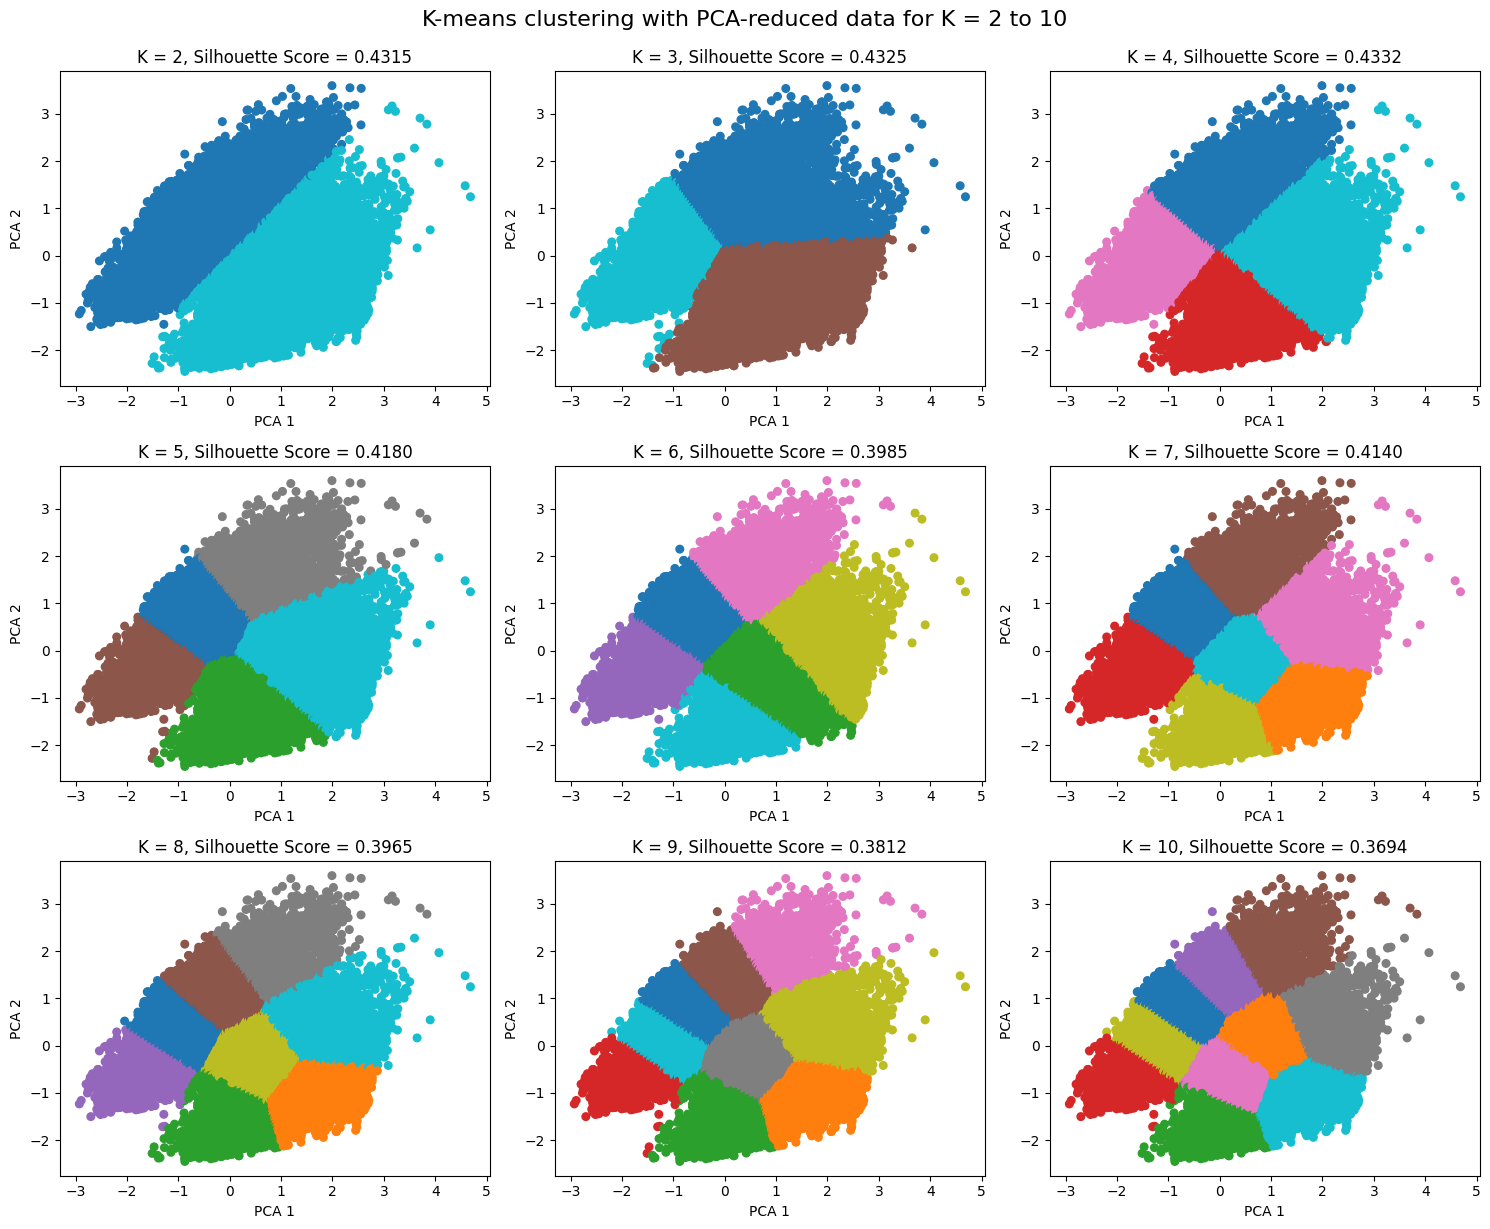

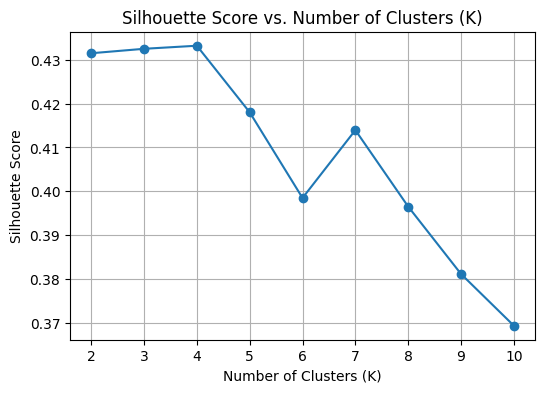

Best K based on silhouette score (K-means with PCA): 4
Silhouette score for K=4 (K-means with PCA): 0.4332


In [ ]:
# Standardize selected features
scaler = StandardScaler()
df_kmeans = df_selected.copy()

print('Data before scaling:')
print(df_kmeans.head())

# Apply scaling
df_kmeans[['Age', 'M/F', 'Official Time']] = scaler.fit_transform(df_kmeans[['Age', 'M/F', 'Official Time']])

print('Data after scaling:')
print(df_kmeans.head())

# Reduce dimensionality to 2 principal components
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_kmeans)

# Initialize storage for silhouette scores
silhouette_scores_kmeans = []
K_range_kmeans = range(2, 11)

# Create subplots for clustering results
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

# Run K-means clustering for K = 2 to 10
for i, k in enumerate(K_range_kmeans):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels_kmeans = kmeans.fit_predict(pca_data)
    score_kmeans = silhouette_score(pca_data, labels_kmeans)
    silhouette_scores_kmeans.append(score_kmeans)

    # Plot PCA-reduced data colored by cluster labels
    axes[i].scatter(pca_data[:, 0], pca_data[:, 1], c=labels_kmeans, cmap='tab10', s=30)
    axes[i].set_title(f'K = {k}, Silhouette Score = {score_kmeans:.4f}')
    axes[i].set_xlabel('PCA 1')
    axes[i].set_ylabel('PCA 2')

plt.tight_layout()
plt.suptitle('K-means clustering with PCA-reduced data for K = 2 to 10', fontsize=16, y=1.02)
plt.show()

# Plot silhouette score vs. number of clusters
plt.figure(figsize=(6,4))
plt.plot(K_range_kmeans, silhouette_scores_kmeans, marker='o')
plt.title('Silhouette Score vs. Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(K_range_kmeans)
plt.grid(True)
plt.show()

# Identify and print the best K based on silhouette score
best_index_kmeans = silhouette_scores_kmeans.index(max(silhouette_scores_kmeans))
best_k_kmeans = range(2, 11)[best_index_kmeans]
best_score_kmeans = silhouette_scores_kmeans[best_index_kmeans]

print(f"Best K based on silhouette score (K-means with PCA): {best_k_kmeans}")
print(f"Silhouette score for K={best_k_kmeans} (K-means with PCA): {best_score_kmeans:.4f}")


# **Gender distribution of clusters (K-means with PCA)**

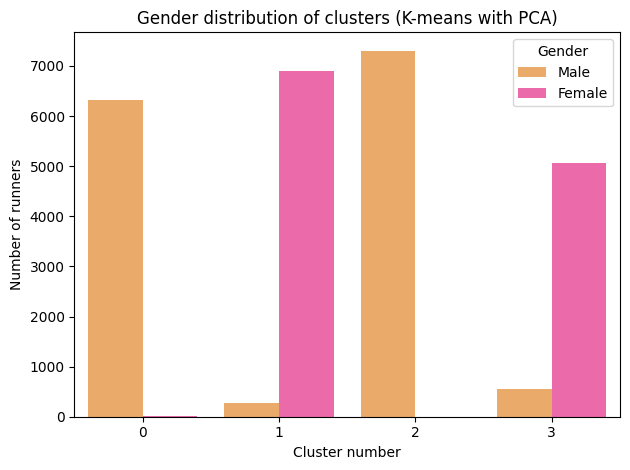

In [ ]:
# Apply KMeans using the best K (from your previous code)
kmeans = KMeans(n_clusters=best_k_kmeans, random_state=42)
df_kmeans['Cluster Number'] = kmeans.fit_predict(pca_data)  # Assign cluster labels to the dataframe

# Reverse the spring palette
reversed_spring = sns.color_palette("spring", n_colors=2)[::-1]  # Get and reverse the spring palette

# Plot the countplot using Seaborn
sns.countplot(data=df_kmeans, x='Cluster Number', hue='M/F', palette=reversed_spring)

# Set the plot title and labels
plt.title(f"Gender distribution of clusters (K-means with PCA)")
plt.xlabel("Cluster number")
plt.ylabel("Number of runners")
plt.xticks(rotation=0)  # Rotate x-axis labels to make them more readable
plt.legend(title='Gender', labels=['Male', 'Female'])

# Show the plot
plt.tight_layout()  # Ensure layout is clean and tight
plt.show()

# **Age distribution of clusters (K-means with PCA)**

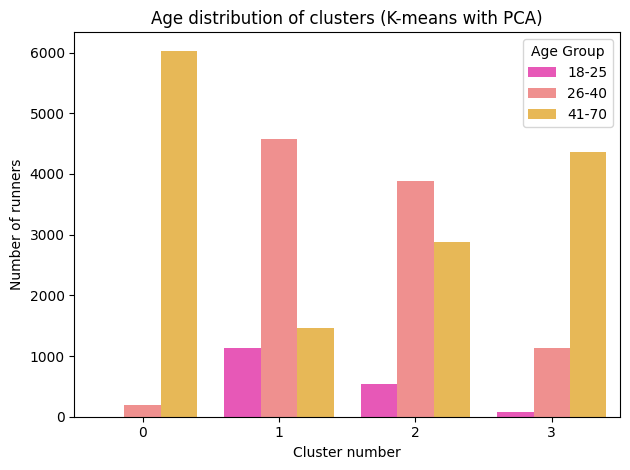

In [ ]:
# Restore the original 'Age' values from the unscaled df_selected
df_kmeans['Age'] = df_selected['Age'].values

# Create a new column for age group categories
def age_group(age):
    if 18 <= age <= 25:
        return '18-25'
    elif 26 <= age <= 40:
        return '26-40'
    elif 41 <= age <= 70:
        return '41-70'
    else:
        return None  # Handle ages outside the specified range by returning None

# Apply the function to create a new 'Age Group' column
df_kmeans['Age Group'] = df_kmeans['Age'].apply(age_group)

# Define the sorted order of age groups
age_order = ['18-25', '26-40', '41-70']

# Now, we will plot the count of runners in each age group for each cluster
#plt.figure(figsize=(6,5))

# Use Seaborn's countplot to visualize the distribution of age groups in each cluster
sns.countplot(data=df_kmeans, x='Cluster Number', hue='Age Group', palette='spring', hue_order=age_order)

# Set titles and labels
plt.title(f"Age distribution of clusters (K-means with PCA)")
plt.xlabel("Cluster number")
plt.ylabel("Number of runners")
plt.xticks(rotation=0)  # Rotate x-axis labels for clarity
plt.legend(title='Age Group', loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

# **Average finishing time of clusters (K-means with PCA)**

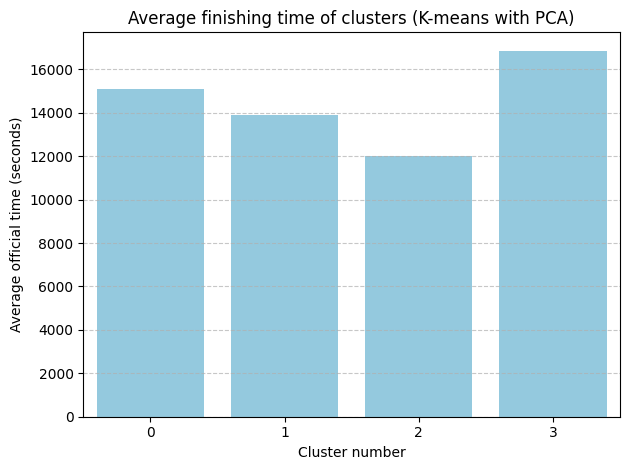

In [ ]:
# Restore the original 'Official Time' values from the unscaled df_selected
df_kmeans['Official Time'] = df_selected['Official Time'].values

# Group by 'Cluster Number' and calculate the mean 'Official Time' (unscaled)
avg_time_per_cluster_kmeans = df_kmeans[['Cluster Number', 'Official Time']].groupby('Cluster Number')['Official Time'].mean().reset_index()

# Plotting the average official time for each cluster
#plt.figure(figsize=(6,4))

# Use Seaborn to create a barplot for average official time by cluster
sns.barplot(data=avg_time_per_cluster_kmeans, x='Cluster Number', y='Official Time', color='skyblue')

# Set titles and labels
plt.title(f"Average finishing time of clusters (K-means with PCA)")
plt.xlabel("Cluster number")
plt.ylabel("Average official time (seconds)")
plt.xticks(rotation=0)  # Rotate x-axis labels for clarity

# Display horizontal grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

# **GMM clustering with t-SNE-reduced data**

Data before scaling:
   Age  M/F  Official Time
0   24    0           7777
1   30    0           7798
2   25    0           7828
3   32    0           7928
4   31    0           7955
Data after scaling:
        Age       M/F  Official Time
0 -1.627754 -0.910605      -2.572945
1 -1.102326 -0.910605      -2.564641
2 -1.540183 -0.910605      -2.552778
3 -0.927183 -0.910605      -2.513234
4 -1.014754 -0.910605      -2.502557


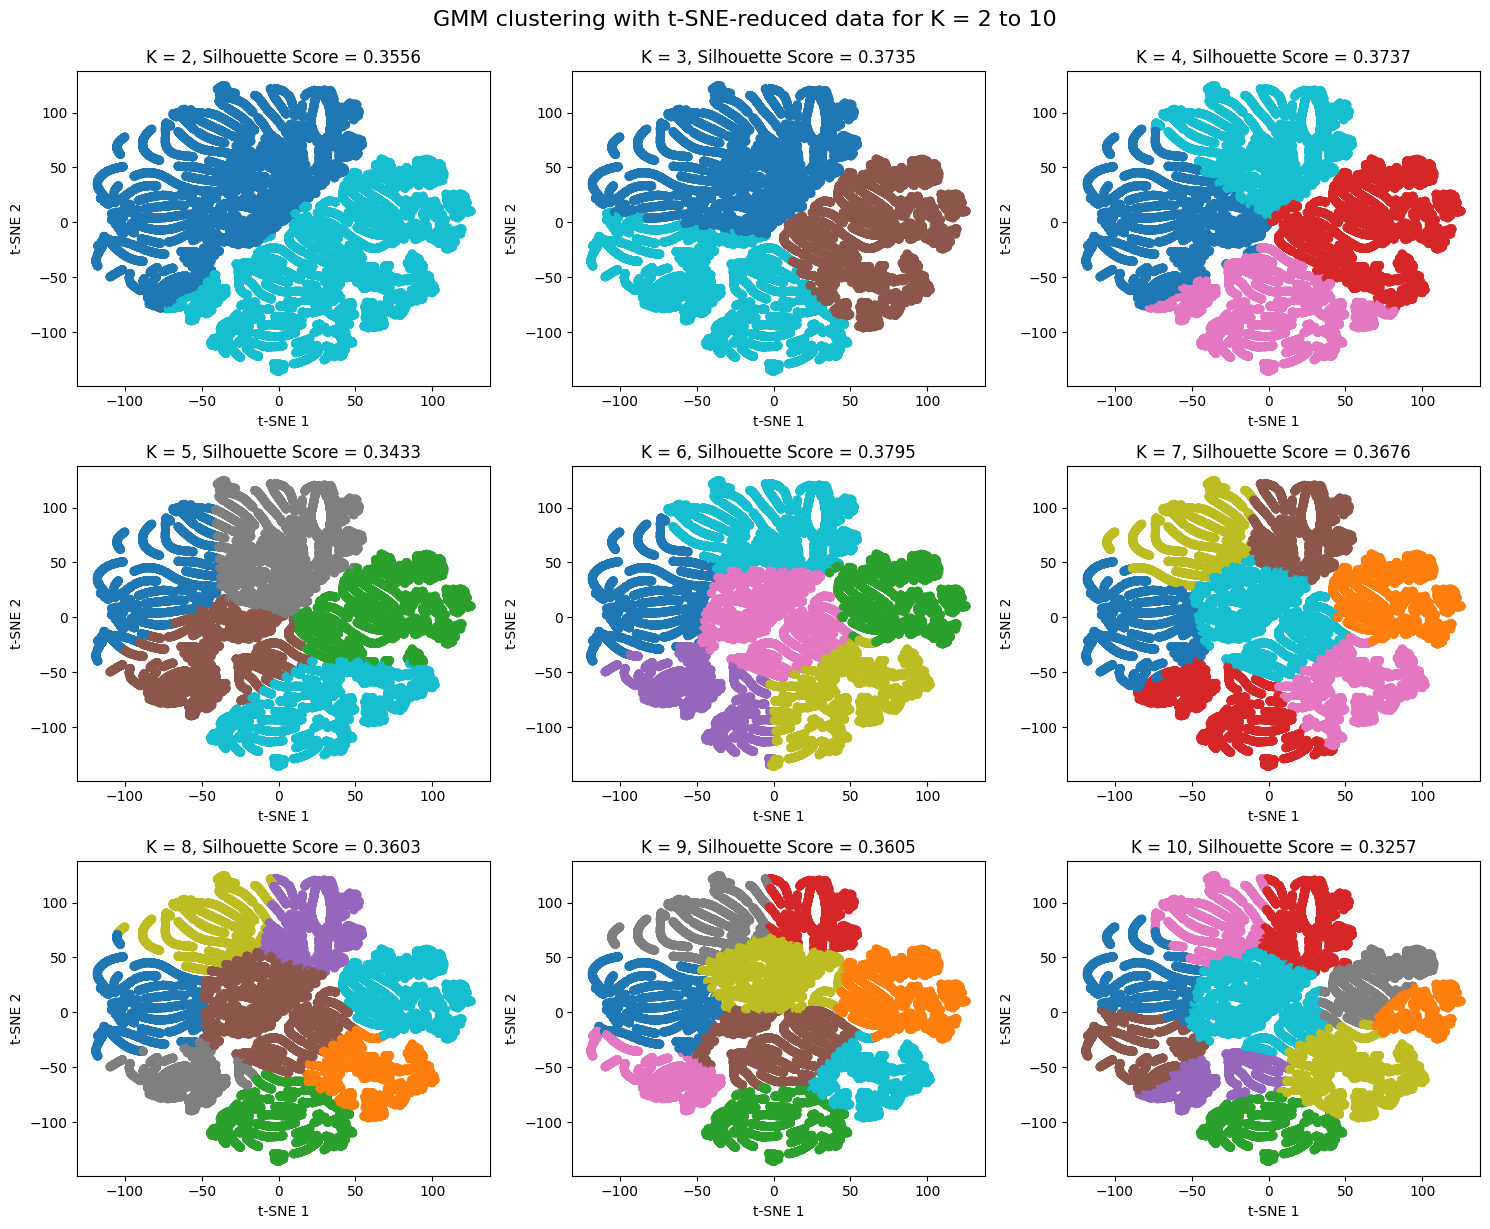

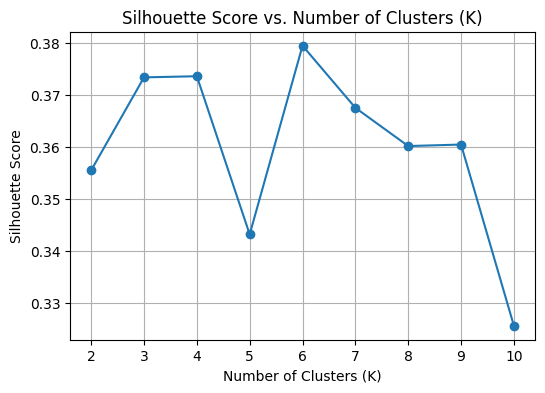

Best K based on silhouette score (GMM with t-SNE): 6
Silhouette score for K=6 (GMM with t-SNE): 0.3795


In [ ]:
# Standardize selected features
scaler = StandardScaler()
df_gmm = df_selected.copy()

print('Data before scaling:')
print(df_gmm.head())

# Apply scaling
df_gmm[['Age', 'M/F', 'Official Time']] = scaler.fit_transform(df_gmm[['Age', 'M/F', 'Official Time']])

print('Data after scaling:')
print(df_gmm.head())

# Reduce dimensionality to 2 principal components
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(df_gmm)

# Initialize storage for silhouette scores
silhouette_scores_gmm = []
K_range_gmm = range(2, 11)

# Create subplots for clustering results
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

# Run GMM clustering for K = 2 to 10
for i, k in enumerate(K_range_gmm):
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels_gmm = gmm.fit_predict(tsne_data)
    score_gmm = silhouette_score(tsne_data, labels_gmm)
    silhouette_scores_gmm.append(score_gmm)

    # Plot tSNE-reduced data colored by cluster labels
    axes[i].scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels_gmm, cmap='tab10', s=30)
    axes[i].set_title(f'K = {k}, Silhouette Score = {score_gmm:.4f}')
    axes[i].set_xlabel('t-SNE 1')
    axes[i].set_ylabel('t-SNE 2')

plt.tight_layout()
plt.suptitle('GMM clustering with t-SNE-reduced data for K = 2 to 10', fontsize=16, y=1.02)
plt.show()

# Plot silhouette score vs. number of clusters
plt.figure(figsize=(6,4))
plt.plot(K_range_gmm, silhouette_scores_gmm, marker='o')
plt.title('Silhouette Score vs. Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(K_range_gmm)
plt.grid(True)
plt.show()

# Identify and print the best K based on silhouette score
best_index_gmm = silhouette_scores_gmm.index(max(silhouette_scores_gmm))
best_k_gmm = range(2, 11)[best_index_gmm]
best_score_gmm = silhouette_scores_gmm[best_index_gmm]

print(f"Best K based on silhouette score (GMM with t-SNE): {best_k_gmm}")
print(f"Silhouette score for K={best_k_gmm} (GMM with t-SNE): {best_score_gmm:.4f}")


# **Gender distribution of clusters (GMM with t-SNE)**

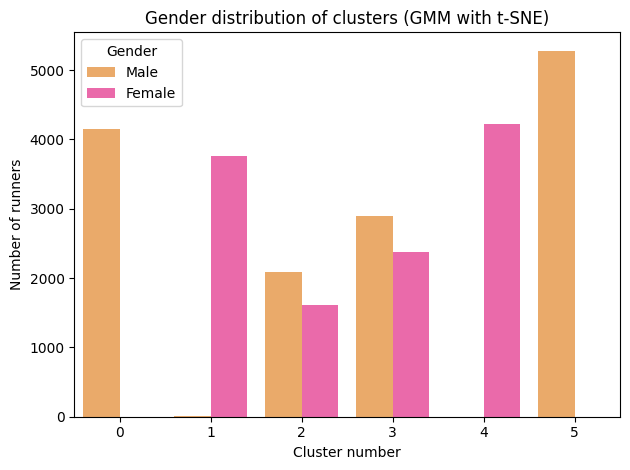

In [ ]:
# Apply GMM using the best K (from your previous code)
gmm = GaussianMixture(n_components=best_k_gmm, random_state=42)
df_gmm['Cluster Number'] = gmm.fit_predict(tsne_data)  # Assign cluster labels to the dataframe

# Reverse the spring palette
reversed_spring = sns.color_palette("spring", n_colors=2)[::-1]  # Get and reverse the spring palette

# Plot the countplot using Seaborn
sns.countplot(data=df_gmm, x='Cluster Number', hue='M/F', palette=reversed_spring)

# Set the plot title and labels
plt.title(f"Gender distribution of clusters (GMM with t-SNE)")
plt.xlabel("Cluster number")
plt.ylabel("Number of runners")
plt.xticks(rotation=0)  # Rotate x-axis labels to make them more readable
plt.legend(title='Gender', labels=['Male', 'Female'])

# Show the plot
plt.tight_layout()  # Ensure layout is clean and tight
plt.show()

# **Age distribution of clusters (GMM with t-SNE)**

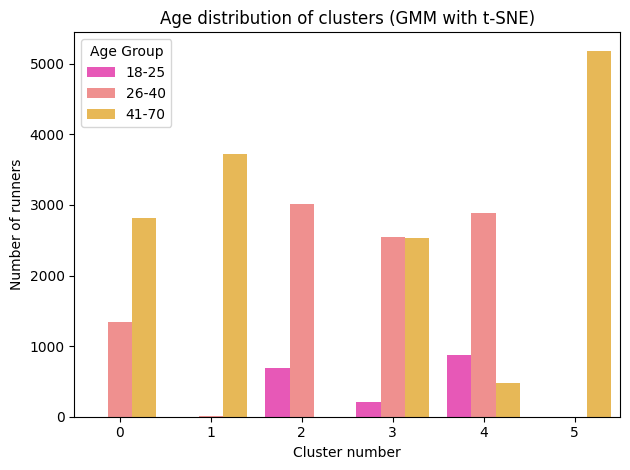

In [ ]:
# Restore the original 'Age' values from the unscaled df_selected
df_gmm['Age'] = df_selected['Age'].values

# Create a new column for age group categories
def age_group(age):
    if 18 <= age <= 25:
        return '18-25'
    elif 26 <= age <= 40:
        return '26-40'
    elif 41 <= age <= 70:
        return '41-70'
    else:
        return None  # Handle ages outside the specified range by returning None

# Apply the function to create a new 'Age Group' column
df_gmm['Age Group'] = df_gmm['Age'].apply(age_group)

# Define the sorted order of age groups
age_order = ['18-25', '26-40', '41-70']

# Now, we will plot the count of runners in each age group for each cluster
#plt.figure(figsize=(6,5))

# Use Seaborn's countplot to visualize the distribution of age groups in each cluster
sns.countplot(data=df_gmm, x='Cluster Number', hue='Age Group', palette='spring', hue_order=age_order)

# Set titles and labels
plt.title(f"Age distribution of clusters (GMM with t-SNE)")
plt.xlabel("Cluster number")
plt.ylabel("Number of runners")
plt.xticks(rotation=0)  # Rotate x-axis labels for clarity
plt.legend(title='Age Group', loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

# **Average finishing time of clusters (GMM with tSNE)**

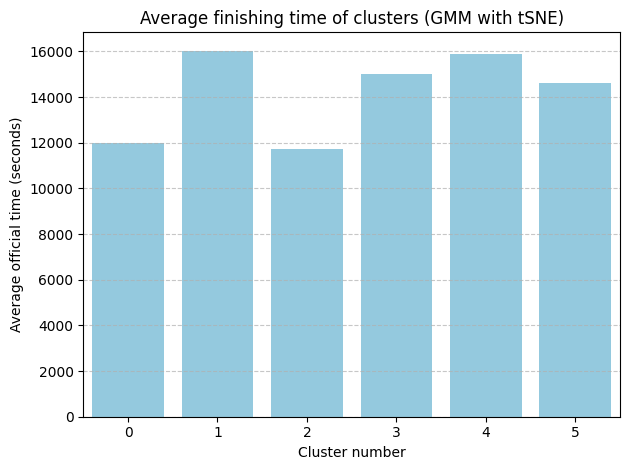

In [ ]:
# Restore the original 'Official Time' values from the unscaled df_selected
df_gmm['Official Time'] = df_selected['Official Time'].values

# Group by 'Cluster Number' and calculate the mean 'Official Time' (unscaled)
avg_time_per_cluster_gmm = df_gmm[['Cluster Number', 'Official Time']].groupby('Cluster Number')['Official Time'].mean().reset_index()

# Plotting the average official time for each cluster
#plt.figure(figsize=(6,4))

# Use Seaborn to create a barplot for average official time by cluster
sns.barplot(data=avg_time_per_cluster_gmm, x='Cluster Number', y='Official Time', color='skyblue')

# Set titles and labels
plt.title(f"Average finishing time of clusters (GMM with tSNE)")
plt.xlabel("Cluster number")
plt.ylabel("Average official time (seconds)")
plt.xticks(rotation=0)  # Rotate x-axis labels for clarity

# Display horizontal grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

**<h1>Boston Marathon - Clustering Project</h1>**

<section>
  <h2>Introduction</h2>
  <p>
    This project analyzes Boston Marathon runners using clustering techniques to identify performance and demographic patterns.
    Using data from the year 2017, we apply unsupervised learning to group runners and explore meaningful insights from these clusters.
  </p>
</section>

<section>
  <h2>Data Preparation</h2>
  <ul>
  <li>Selected relevant columns: <code>Age</code>, <code>M/F</code>, and <code>Official Time</code>.</li>
  <li>Converted the <code>M/F</code> column to numeric format (0 for Male, 1 for Female).</li>
  <li>Transformed <code>Official Time</code> from <code>HH:MM:SS</code> or <code>MM:SS</code> string format to total seconds.</li>
  <li>Applied a custom function to perform the time conversion safely, handling errors and missing values.</li>
  <li>Dropped all rows containing <code>NaN</code> values to ensure clean data.</li>
</ul>
</section>

<section>
  <h2>Methodology</h2>
  <p>
    We used two clustering techniques to uncover patterns in runner demographics and performance.
  </p>
  <ul>
    <li>
     <strong>K-means with PCA: </strong>Principal Component Analysis (PCA) was applied to reduce the dataset to two dimensions, enabling visual interpretation of K-means clusters. K-means clustering was performed for K values ranging from 2 to 10. The optimal number of clusters was chosen based on the silhouette score, which measures how well-separated the clusters are.
    </li>
    <li>
     <strong>GMM with t-SNE: </strong>t-distributed Stochastic Neighbor Embedding (t-SNE) was used to reduce dimensions for Gaussian Mixture Model (GMM) clustering visualization. GMM clustering was performed for K values ranging from 2 to 10. The optimal number of clusters was chosen based on the silhouette score.
    </li>
   </ul>
   <p>
      For both methods, we analyzed clusters in terms of gender distribution, age distribution and average finishing time.
   </p>
</section>

<section>
  <h2>K-means with PCA:</h2>
  <ul>
  <li>Best K = 4 </li>
  <li>Best Silhouette score = 0.4332</li>
  <li><strong>Gender distribution observations:</strong>
    <ul>
       <li>Cluster 0 and 2 are almost completely male, with hardly any females. Cluster 2 has the highest number of males.</li>
       <li>Cluster 1 and 3 are predominantly female, with a small number of males. Cluster 1 has the highest number of females.</li>
    </ul>
  </li>
  <li><strong>Age distribution observations:</strong>
    <ul>
       <li>18-25: This group has the least number of runners. They are mainly in clusters 1 and 2. Cluster 1 has the highest number of 18-25 age group runners but this is still less compared to the number of runners from the other 2 groups.</li>
       <li>26-40: They are mainly in clusters 1, 2 and 3. Cluster 1 has the highest number of 26-40 age group runners.</li>
       <li>41-70: This group has the highest number of runners. They are spread across all four clusters. Cluster 0 has the highest number of 41-70 age group runners. Cluster 0 is dominated by this age group runners.</li>
    </ul>
  </li>
  <li><strong>Average finishing time observations:</strong>
    <ul>
       <li>There is not a huge variation in the average finishing time of the 4 clusters.</li>
       <li>Cluster 2 has the fastest runners.</li>
       <li>Cluster 3 has the slowest runners.</li>
    </ul>
  </li>
  </ul>
</section>
    
<section>
  <h2>GMM with t-SNE</h2>
  <ul>
  <li>Best K = 6 </li>
  <li>Best Silhouette score = 0.3795</li>
  <li><strong>Gender distribution observations:</strong>
    <ul>
       <li>Cluster 0 and 5 are almost completely male, with almost no females. Cluster 5 has the highest number of males.</li>
       <li>Cluster 1 and 4 are almost completely female, with almost no males. Cluster 4 has the highest number of females.</li>
       <li>Cluster 2 and 3 have a balanced mix of males and females.</li>
    </ul>
  </li>
  <li><strong>Age distribution observations:</strong>
    <ul>
       <li>18-25: This group has the least number of runners. They are mostly in clusters 2 and 4. Cluster 4 has the highest number of 18-25 age group runners.</li>
       <li>26-40: They are in clusters 0, 2, 3 and 4. Cluster 2 has the highest number of 26-40 age group runners, followed by cluster 4 at a close second spot.</li>
       <li>41-70: This group has the highest number of runners. Clusters 1 and 5 almost completely consist of this group of runners. They are also well-represented in clusters 0 and 3. Cluster 5 has the highest number of 41-70 age group runners.</li>
    </ul>
  </li>
  <li><strong>Average finishing time observations:</strong>
    <ul>
       <li>There is not a huge variation in the average finishing time of the 6 clusters.</li>
       <li>Cluster 2 has the fastest runners.</li>
       <li>Cluster 1 has the slowest runners.</li>
    </ul>
  </li>
  </ul>
</section>

<section>
  <h2>Conclusions</h2>
  <ul>
  <li>Both <strong>K-means with PCA</strong> and <strong>GMM with t-SNE</strong> gave us clear and useful results.</li>
  <li>We could easily spot which clusters had more male or female runners.</li>
  <li>Age distributions were clear too — we saw which clusters had the youngest and oldest participants.</li>
  <li>We also identified which clusters had the fastest finishers.</li>
  <li>Overall, both methods helped reveal meaningful patterns in the marathon data.</li>
</ul>
</section>
